In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Functions
#from Configs_Ascaso_Ext_Analysis import Binningf

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split
import os


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs

from clevar.match import output_matched_catalog
import clevar
clevar.__version__



'0.14.1'

In [2]:
min_richness = 5
min_halo_mass = 1e13 #Msun

#Halos/Clusters
#CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

#CosmoDC2: 'cosmoDC2_v1.1.4_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

#Members
RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/cosmoDC2_RM_match_cross_membership')

#Matched Data
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

cdc2_dt = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['z']], names=('m200c', 'richness', 'redshift_true'))


RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    45,081
 * multiple (self):  43,213
 * multiple (other): 43,213
 * unique (self):    43,035
 * unique (other):   43,037
 * cross:            43,035

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    471,457
 * multiple (self):  75,785
 * multiple (other): 75,785
 * unique (self):    43,037
 * unique (other):   43,035
 * cross:            43,035


In [3]:
min_richness = 5
min_halo_mass = 1e13 #Msun

#Halos/Clusters
#SkySim + RedMaPPer: 'skysim5000_v1.1.1_redmapper_v0.8.5'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

#SkySim: 'skysim5000_v1.1.1_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

#Members
RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/SS_RM_match_cross_membership')

RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

ss_dt = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['z']], names=('m200c', 'richness', 'redshift_true'))



RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    46,491
 * multiple (self):  3,921
 * multiple (other): 3,921
 * unique (self):    3,920
 * unique (other):   3,920
 * cross:            3,920

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    249,495
 * multiple (self):  9,756
 * multiple (other): 9,756
 * unique (self):    3,920
 * unique (other):   3,920
 * cross:            3,920


In [4]:
ascaso = Nc.ClusterMassAscaso()
lnrich_ext = Nc.ClusterMassLnrichExt()

def catalog_fit(dt_halos):
    rmdata = create_richness_mass_calib(dt_halos)

    fixed_parameters_ascaso = [6] #fixing cut parameter


    ascaso.param_set_by_name("cut", 1e15) #Set cut parameter value 
    mset = Ncm.MSet()
    mset.set(ascaso)
    rmdata.m2lnL_val(mset)  
    mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)

    #All parameters free except cut parameters:
    for par in fixed_parameters_ascaso:
        mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)

    mset.prepare_fparam_map()

    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()

    fixed_parameters_lnrich_ext = [12, 13, 14, 15] #fixing cut parameters


    lnrich_ext.param_set_by_name("cut", 1e15) #Set cut parameter value 
    mset = Ncm.MSet()
    mset.set(lnrich_ext)
    rmdata.m2lnL_val(mset)  
    mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)

    #All parameters free except cut parameters:
    for par in fixed_parameters_lnrich_ext:
        mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)

    mset.prepare_fparam_map()

    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()


In [5]:
def compute_res(rich_model):
    lnM = np.log(dt_halos["m200c"])  # ln(mass)
    z = dt_halos["redshift_true"]  # redshift
    lnR = np.log(dt_halos["richness"])  # ln(richness)

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 1000000

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    
    lnR_std=lnR_std[sigma_cut_array]
    dt_halos_res = dt_halos[sigma_cut_array]
    
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnR_std, dt_halos_res

catalog_fit(cdc2_dt)
dt_halos = cdc2_dt

res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnR_std_ascaso, dt_halos_ascaso = compute_res(ascaso)
res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnR_std_ext, dt_halos_ext = compute_res(lnrich_ext)

catalog_fit(ss_dt)
dt_halos=ss_dt

SS_res_ascaso, SS_lnR_mean_ascaso, SS_z_sigma_cut_ascaso, SS_lnM_sigma_cut_ascaso, SS_lnR_std_ascaso, SS_dt_halos_ascaso = compute_res(ascaso)
SS_res_ext, SS_lnR_mean_ext, SS_z_sigma_cut_ext, SS_lnM_sigma_cut_ext, SS_lnR_std_ext, SS_dt_halos_ext = compute_res(lnrich_ext)


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

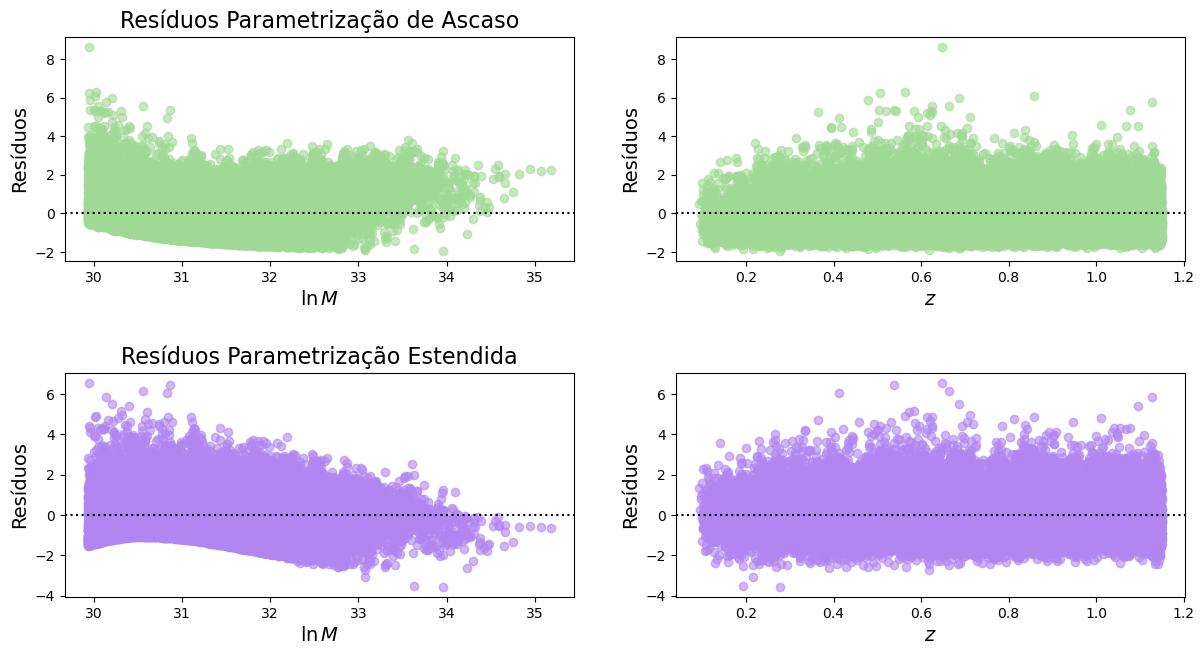

In [6]:
fig = plt.figure(figsize=(14,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="#a0d995", alpha=0.6)
ax1.set_xlabel("$\ln M$", fontsize=14)
ax1.set_ylabel("Resíduos", fontsize=14)
ax1.axhline(y=0.0, color='black', linestyle='dotted')
ax1.set_title("Resíduos Parametrização de Ascaso", fontsize=16)

ax2.scatter(z_sigma_cut_ascaso, res_ascaso,  c="#a0d995", alpha=0.6)
ax2.set_xlabel("$z$", fontsize=14)
ax2.set_ylabel("Resíduos", fontsize=14)
ax2.axhline(y=0.0, color='black', linestyle='dotted')

ax3.scatter(lnM_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax3.set_xlabel("$\ln M$", fontsize=14)
ax3.set_ylabel("Resíduos", fontsize=14)
ax3.set_title("Resíduos Parametrização Estendida", fontsize=16)
ax3.axhline(y=0.0, color='black', linestyle='dotted')

ax4.scatter(z_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax4.set_xlabel("$z$", fontsize=14)
ax4.set_ylabel("Resíduos", fontsize=14)
ax4.axhline(y=0.0, color='black', linestyle='dotted')

plt.show()

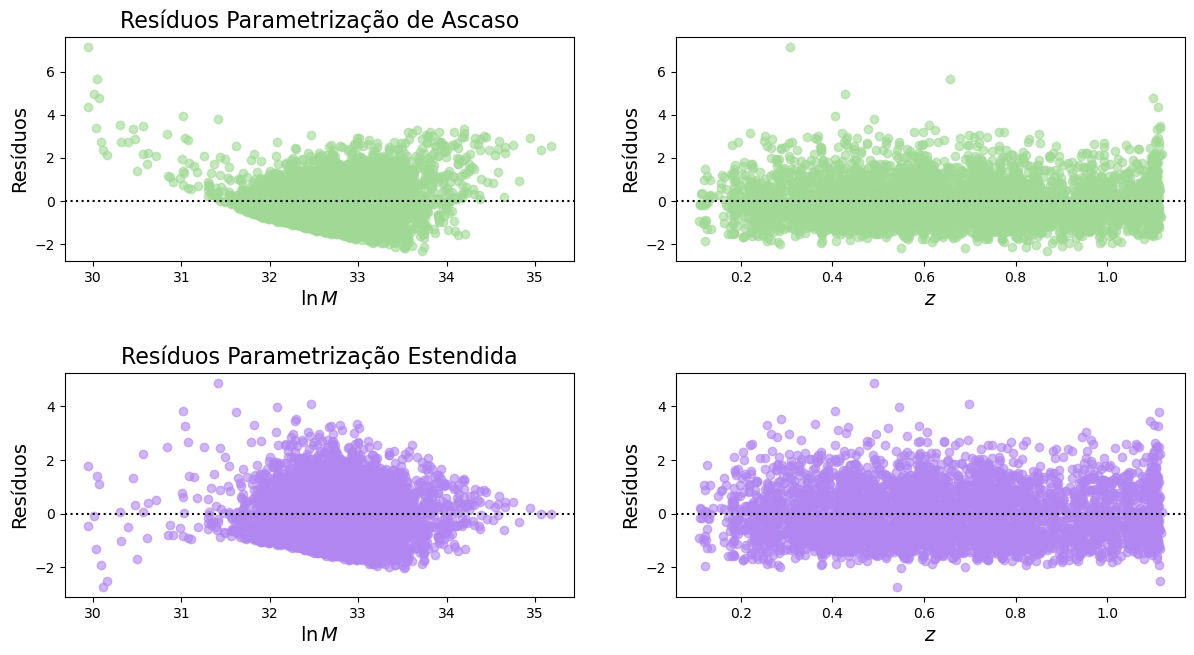

In [7]:
fig = plt.figure(figsize=(14,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(SS_lnM_sigma_cut_ascaso, SS_res_ascaso, c="#a0d995", alpha=0.6)
ax1.set_xlabel("$\ln M$", fontsize=14)
ax1.set_ylabel("Resíduos", fontsize=14)
ax1.axhline(y=0.0, color='black', linestyle='dotted')
ax1.set_title("Resíduos Parametrização de Ascaso", fontsize=16)

ax2.scatter(SS_z_sigma_cut_ascaso, SS_res_ascaso,  c="#a0d995", alpha=0.6)
ax2.set_xlabel("$z$", fontsize=14)
ax2.set_ylabel("Resíduos", fontsize=14)
ax2.axhline(y=0.0, color='black', linestyle='dotted')

ax3.scatter(SS_lnM_sigma_cut_ext, SS_res_ext, c="#b186f1", alpha=0.6)
ax3.set_xlabel("$\ln M$", fontsize=14)
ax3.set_ylabel("Resíduos", fontsize=14)
ax3.set_title("Resíduos Parametrização Estendida", fontsize=16)
ax3.axhline(y=0.0, color='black', linestyle='dotted')

ax4.scatter(SS_z_sigma_cut_ext, SS_res_ext, c="#b186f1", alpha=0.6)
ax4.set_xlabel("$z$", fontsize=14)
ax4.set_ylabel("Resíduos", fontsize=14)
ax4.axhline(y=0.0, color='black', linestyle='dotted')

plt.show()

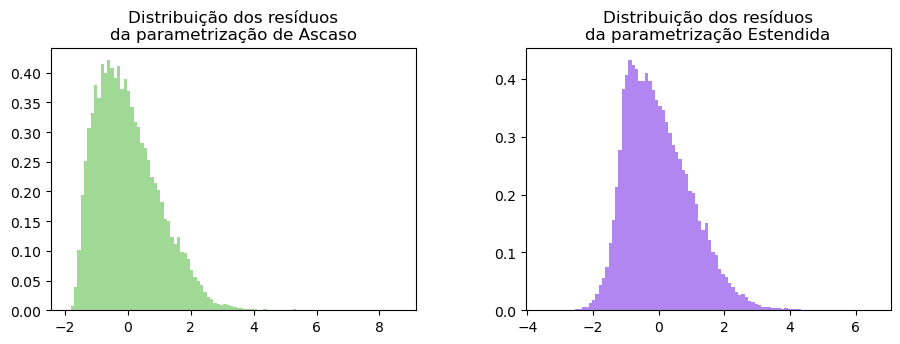

In [8]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

ax1.hist(res_ascaso, bins=100, density=True, color ="#a0d995")
ax1.set_title("Distribuição dos resíduos\nda parametrização de Ascaso")

ax2.hist(res_ext, bins=100, density=True, color="#b186f1")
ax2.set_title("Distribuição dos resíduos\nda parametrização Estendida")

plt.show()

In [9]:
print(stats.kstest(res_ascaso, stats.norm.cdf, args=(np.mean(res_ascaso), np.std(res_ascaso))))
print(stats.kstest(res_ext, stats.norm.cdf, args=(np.mean(res_ext), np.std(res_ext))))

KstestResult(statistic=0.06122125464875394, pvalue=1.1649325922847432e-140, statistic_location=-0.24200724053473405, statistic_sign=1)
KstestResult(statistic=0.059483718914978834, pvalue=8.300727547819957e-133, statistic_location=-0.2630201542295613, statistic_sign=1)
